# Vector Space Semantics for Similarity between Eastenders Characters
we will be creating a vector representation of a document containing lines spoken by a character in the Eastenders script data (i.e. from the file `training.csv`), then improving that representation such that each character vector is maximially distinguished from the other character documents. This distinction is measured by how well a simple information retrieval classification method can select documents from validation and test data as belonging to the correct class of document (i.e. deciding which character spoke the lines by measuring the similarity of those character document vectors to those built in training).

As the lines are not evenly distributed in terms of frequency, we are using a maximum of the first **400 lines** of each character in the training data `training.csv` to create the training documents, and a maximum of the first **40 lines** in the test data (from `test.csv`). This makes it more challenging, as number of lines spoken by a character can't be used directly or otherwise as a feature.


## PIPE LINE
The pipeline of similarity-based information retrieval based evaluation.
1.   Loading training and test data into a dataframe.
2. Splitting the training data for held-out validation with random samples of 9:1 train/heldout split.

1.   Joining the 360 charecter spoken lines of each charecter in create_character_document_from_dataframe of the training data and 40 charecter spoken lines of each charecter for validation data.
1.   Processing feature enginnering(Pre-processing, Feature Extraction) of each charecter documents. 
2. Converting the charecter documents of unique charecter to matrix by vectorizing the dictionary in order to compute cosine similarity and find the similarity between each charecter.

1.   Computes an information retrieval based on training data feature matrix and test data feature matrix returns 4 tuples namely,

 ::mean_rank:: mean of the ranking of the target document in terms of similarity to the query/test document 1 is the best possible score.
   
    ::mean_cosine_similarity:: mean cosine similarity score for the target document vs. the test document of the same class
   
    ::accuracy:: proportion of test documents correctly classified
    
    ::df:: a data frame with all the similarity measures of the test documents vs. train documents

1. Closely observing why there isn't a successful highest match between the target character in the training set and that character's vector in the heldout set yet by identifying how their language use is similar, resulting in similar word or ngram features.

1.   Testing the performance on the test data 

*Note: Obtained a mean rank of 1. Found best suitable pre-processing, feature extraction and transformation techniques for charecter vector representation.*

In [53]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [54]:
import string
import re
import numpy as np
from numpy.linalg import norm
import pandas as pd
from collections import Counter, OrderedDict

import seaborn as sns
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
from sklearn.feature_extraction import DictVectorizer
from nltk.stem import PorterStemmer, WordNetLemmatizer 
%matplotlib inline
pd.options.display.max_colwidth=500

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [55]:
# Load in training data and display in pandas dataframe
train_path='training.csv'
all_train_data = pd.read_csv(train_path,  delimiter="\t", skip_blank_lines = True)
test_path ='test.csv'
test_data = pd.read_csv(test_path,  delimiter="\t", skip_blank_lines = True)

# Inspect
all_train_data

,Episode,Scene,Scene_info,Character_name,Line,Gender
0,1350,1,DESERTED CAR PARK EXT NIGHT,SHIRLEY,"Look at ya, not a mark on ya. And you think you're an unlucky man.",FEMALE
1,1350,1,DESERTED CAR PARK EXT NIGHT,OTHER,Shirl...,MALE
2,1350,2,R&R INT NIGHT,JACK,Oi. Where have you been? Huh? What were the texts about?,MALE
3,1350,2,R&R INT NIGHT,RONNIE,Nothing. Nothing. I'll be with you in two minutes yeah?,FEMALE
4,1350,2,R&R INT NIGHT,JACK,"Well I've got mates here I wanted to have a chat with them, instead I've been serving behind the bar.",MALE
...,...,...,...,...,...,...
15314,1399,55,SQUARE EXT DAY LIGHT,OTHER,"Dad? Okay ... alright, just one drink alright. But that's all. It doesn't mean anything. It's just a drink.",MALE
15315,1399,55,SQUARE EXT DAY LIGHT,MAX,Thanks Bradley. Thanks mate... It means the world to me...,MALE
15316,1399,55,SQUARE EXT DAY LIGHT,OTHER,You alright...,MALE
15317,1399,55,SQUARE EXT DAY LIGHT,MAX,"Yeah, yeah, yeah. I'm fine.",MALE


In [56]:
# Split into training and test data for heldout validation with random samples of 9:1 train/heldout split
from random import shuffle, seed

seed(0) # set a seed for reproducibility so same split is used each time

epsiode_scene_column = all_train_data.Episode.astype(str) + "-" + all_train_data.Scene.astype(str)
all_train_data['episode_scene'] = epsiode_scene_column
episode_scenes = sorted(list(set([x for x in epsiode_scene_column.values]))) # need to sort to ensure same initial order

shuffle(episode_scenes)

print(len(episode_scenes))
episode_split = int(0.9*len(episode_scenes))
training_ep_scenes = episode_scenes[:episode_split]
test_ep_scenes = episode_scenes[episode_split:]
print(len(training_ep_scenes), len(test_ep_scenes))

def train_or_heldout_eps(val):
    if val in training_ep_scenes:
        return "training"
    return "heldout"

all_train_data['train_heldout'] = all_train_data['episode_scene'].apply(train_or_heldout_eps)

1394
1254 140


In [57]:
print('Raw Data: ',np.shape(all_train_data))
train_data = all_train_data[all_train_data['train_heldout']=='training']
val_data = all_train_data[all_train_data['train_heldout']=='heldout']
print('Train set: ',np.shape(train_data))
print('Validation set: ',np.shape(val_data))

Raw Data:  (15319, 8)
Train set:  (13638, 8)
Validation set:  (1681, 8)


In [58]:
train_data

,Episode,Scene,Scene_info,Character_name,Line,Gender,episode_scene,train_heldout
0,1350,1,DESERTED CAR PARK EXT NIGHT,SHIRLEY,"Look at ya, not a mark on ya. And you think you're an unlucky man.",FEMALE,1350-1,training
1,1350,1,DESERTED CAR PARK EXT NIGHT,OTHER,Shirl...,MALE,1350-1,training
2,1350,2,R&R INT NIGHT,JACK,Oi. Where have you been? Huh? What were the texts about?,MALE,1350-2,training
3,1350,2,R&R INT NIGHT,RONNIE,Nothing. Nothing. I'll be with you in two minutes yeah?,FEMALE,1350-2,training
4,1350,2,R&R INT NIGHT,JACK,"Well I've got mates here I wanted to have a chat with them, instead I've been serving behind the bar.",MALE,1350-2,training
...,...,...,...,...,...,...,...,...
15314,1399,55,SQUARE EXT DAY LIGHT,OTHER,"Dad? Okay ... alright, just one drink alright. But that's all. It doesn't mean anything. It's just a drink.",MALE,1399-55,training
15315,1399,55,SQUARE EXT DAY LIGHT,MAX,Thanks Bradley. Thanks mate... It means the world to me...,MALE,1399-55,training
15316,1399,55,SQUARE EXT DAY LIGHT,OTHER,You alright...,MALE,1399-55,training
15317,1399,55,SQUARE EXT DAY LIGHT,MAX,"Yeah, yeah, yeah. I'm fine.",MALE,1399-55,training


In [59]:
if False:
    # A simpler alternative to the above, but where a high split means some characters
    # may be left out
    print('Raw Data: ',np.shape(all_train_data))
    idx = int(0.9 * np.shape(all_train_data)[0])
    train_data = all_train_data[:idx]
    val_data = all_train_data[idx:]
    print('Train set: ',np.shape(train_data))
    print('Validation set: ',np.shape(val_data))

In [60]:
# Create one document per character
def create_character_document_from_dataframe(df, max_line_count):
    """Returns a dict with the name of the character as key,
    their lines joined together as a single string, with end of line _EOL_
    markers between them.
    
    ::max_line_count:: the maximum number of lines to be added per character
    """
    character_docs = {}
    character_line_count = {}
    for line, name, gender in zip(df.Line, df.Character_name, df.Gender):
        if not name in character_docs.keys():
            character_docs[name] = ""
            character_line_count[name] = 0
        if character_line_count[name]==max_line_count:
            continue
        character_docs[name] += str(line)   + " _EOL_ "  # adding an end-of-line token
        character_line_count[name]+=1
    print("lines per character", character_line_count)
    return character_docs

In [61]:
# print out the number of words each character has in the training set
# only use the first 360 lines of each character
train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=360)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

lines per character {'SHIRLEY': 360, 'OTHER': 360, 'JACK': 360, 'RONNIE': 360, 'TANYA': 360, 'SEAN': 360, 'ROXY': 360, 'HEATHER': 360, 'MAX': 360, 'IAN': 360, 'JANE': 360, 'STACEY': 360, 'PHIL': 360, 'MINTY': 360, 'CHRISTIAN': 342, 'CLARE': 352}
Num. Characters:  16 

SHIRLEY Number of Words:  3848
OTHER Number of Words:  3244
JACK Number of Words:  4435
RONNIE Number of Words:  3442
TANYA Number of Words:  3786
SEAN Number of Words:  3637
ROXY Number of Words:  3838
HEATHER Number of Words:  4098
MAX Number of Words:  4363
IAN Number of Words:  4332
JANE Number of Words:  3648
STACEY Number of Words:  3913
PHIL Number of Words:  3635
MINTY Number of Words:  4005
CHRISTIAN Number of Words:  3738
CLARE Number of Words:  4344
total words 62306


In [62]:
def pre_process(character_text):
    """Pre-process all the concatenated lines of a character, 
    using tokenization, spelling normalization and other techniques.
    
    Initially just a tokenization on white space. Improve this for Q1.
    
    ::character_text:: a string with all of one character's lines
    """
    # Tokenizing the words and removing puncuation marks
    tokenise = RegexpTokenizer(r'\w+')
    tokens = tokenise.tokenize(character_text)
  
    # lowercasing
    token = [t.lower() for t in tokens]
    
    # stopword removal 
    stop = set(stopwords.words('english'))
    token = [t for t in token if t not in stop]
    # Stemming words through porter stemmer
    p_stemmer = PorterStemmer()
    token = [p_stemmer.stem(t)  for t in token]
    return token

In [63]:
# create list of pairs of (character name, pre-processed character) 
training_corpus = [(name, pre_process(doc)) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc in training_corpus]

In [64]:
def to_feature_vector_dictionary(character_doc, extra_features):
    """Converts a list of pre-processed tokens and extra features
    to a Dictionary as a function of the tokens.
    
    Initially just a simple count. 
    
    ::character_doc:: a list of pre-processed tokens
    ::extra_features:: any extra features for the character to be added to feature vector dict
    """
    counts = Counter(character_doc)  # for now a simple count
    counts = dict(counts)
    # add the extra features, for now just adding one count for each extra feature
    for feature in extra_features:
        counts[feature] += 1
    return counts  

In [65]:
from nltk import ngrams
# filtering the documents based on the mi_df and max_df
def filter_documents(corpus, min_df=1, max_df=1, fitting=False):
    f_dicts, label = [], []
    
    # Counting the words in the documents
    count_words = Counter()
    for key, doc in corpus:
        label.append(key)
        n=1  #(unigram)
        features = to_feature_vector_dictionary(doc,[])
        count_words.update(features.keys())
        f_dicts.append(features)
    
    # Filtering the words using min_df and max_df
    if fitting:
        for f_dict in f_dicts:
            for feature in list(f_dict.keys()):
                if not min_df <= count_words[feature] / len(f_dicts) <= max_df:
                    del f_dict[feature]
    
    # returning the keys/names and feature dictionary 
    return f_dicts, label

In [66]:
# Using k-best method with k/num_features as 800 for feature reduction
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

# Pipeline with DictVectorizer and k-best selection methods
pipeline = Pipeline([('vectorizer', DictVectorizer()),
                     #('tf-idf', TfidfTransformer(norm='l1', use_idf=False, smooth_idf=False, sublinear_tf=False)),
                     ('k-best', SelectKBest(score_func=chi2, k=800))
                     ])

def create_document_matrix_from_corpus(corpus, fitting=False):
    """
    Method which fits different vectorizers on data and returns a matrix.
    Currently just does simple conversion to matrix by vectorizing the dictionary. Improve this for Q3.
    
    ::corpus:: a list of (class_label, document) pairs.
    ::fitting:: a boolean indicating whether to fit/train the vectorizers (should be true on training data)
    """
    # Performing manual tf idf
    feature_dicts, labels = filter_documents(corpus, min_df=0, max_df=0.99, fitting=fitting)
    
    # Fitting feature dictionaries using the pipeline if fitting set to true
    if fitting:
        pipeline.fit(feature_dicts, labels)
    
    # Transforming the feature dictionaries using the fitted pipeline
    doc_feature_matrix = pipeline.transform(feature_dicts)
    
    return doc_feature_matrix

In [67]:
training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)
training_feature_matrix

<16x800 sparse matrix of type '<class 'numpy.float64'>'
	with 4239 stored elements in Compressed Sparse Row format>

In [68]:
# get the validation data- only 40 lines used for each character
val_character_docs = create_character_document_from_dataframe(val_data, max_line_count=40)
print('Num. Characters: ',len(val_character_docs.keys()),"\n")
total_words = 0
for name in val_character_docs.keys():
    print(name, 'Num of Words: ',len(val_character_docs[name].split()))
    total_words += len(val_character_docs[name].split())
print("total words", total_words)

# create list of pairs of (character name, pre-processed character) 
val_corpus = [(name, pre_process(doc)) for name, doc in sorted(val_character_docs.items())]
val_labels = [name for name, doc in val_corpus]

lines per character {'TANYA': 40, 'MAX': 40, 'SEAN': 35, 'SHIRLEY': 40, 'OTHER': 40, 'STACEY': 40, 'RONNIE': 40, 'JACK': 40, 'PHIL': 40, 'IAN': 40, 'JANE': 40, 'ROXY': 40, 'HEATHER': 40, 'MINTY': 40, 'CHRISTIAN': 40, 'CLARE': 40}
Num. Characters:  16 

TANYA Num of Words:  438
MAX Num of Words:  737
SEAN Num of Words:  366
SHIRLEY Num of Words:  329
OTHER Num of Words:  357
STACEY Num of Words:  412
RONNIE Num of Words:  464
JACK Num of Words:  351
PHIL Num of Words:  475
IAN Num of Words:  508
JANE Num of Words:  458
ROXY Num of Words:  392
HEATHER Num of Words:  411
MINTY Num of Words:  470
CHRISTIAN Num of Words:  489
CLARE Num of Words:  405
total words 7062


In [69]:
# Just transform the val_feature_matrix, don't fit
val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False)

In [70]:
val_feature_matrix

<16x800 sparse matrix of type '<class 'numpy.float64'>'
	with 860 stored elements in Compressed Sparse Row format>

In [71]:
def compute_cosine_similarity(v1, v2):
    """Takes a pair of vectors v1 and v2 (1-d arrays e.g. [0, 0.5, 0.5])
    returns the cosine similarity between the vectors
    """
    
    # compute cosine similarity manually
    manual_cosine_similarity = np.dot(v1, v2)  /(norm(v1) * norm(v2))
    
    return manual_cosine_similarity

In [72]:
def compute_IR_evaluation_scores(train_feature_matrix, test_feature_matrix, train_labels, test_labels):
    """
    Computes an information retrieval based on training data feature matrix and test data feature matrix
    returns 4-tuple:
    ::mean_rank:: mean of the ranking of the target document in terms of similarity to the query/test document
    1 is the best possible score.
    ::mean_cosine_similarity:: mean cosine similarity score for the target document vs. the test document of the same class
    ::accuracy:: proportion of test documents correctly classified
    ::df:: a data frame with all the similarity measures of the test documents vs. train documents
    
    params:
    ::train_feature_matrix:: a numpy matrix N x M shape where N = number of characters M = number of features
    ::test_feature_matrix::  a numpy matrix N x M shape where N = number of characters M = number of features
    ::train_labels:: a list of character names for the training data in order consistent with train_feature_matrix
    ::test_labels:: a list of character names for the test data in order consistent with test_feature_matrix
    """
    rankings = []
    all_cosine_similarities = []
    pairwise_cosine_similarity = []
    pairs = []
    correct = 0
    for i, target in enumerate(test_labels):
        # compare the left out character against the mean
        idx = i 
        fm_1 = test_feature_matrix.toarray()[idx]
        all_sims = {}
        # print("target:", target)
        for j, other in enumerate(train_labels):
            fm_2 = train_feature_matrix.toarray()[j]
            manual_cosine_similarity = compute_cosine_similarity(fm_1, fm_2)
            pairs.append((target, other))
            pairwise_cosine_similarity.append(manual_cosine_similarity)
            if other == target:
                all_cosine_similarities.append(manual_cosine_similarity)
            all_sims[other] = manual_cosine_similarity

           # print(target, other, manual_cosine_similarity)
        sorted_similarities = sorted(all_sims.items(),key=lambda x:x[1],reverse=True)
        # print(sorted_similarities)
        ranking = {key[0]: rank for rank, key in enumerate(sorted_similarities, 1)}
        #print("Ranking for target", ranking[target], target, other)
        if ranking[target] == 1:
            correct += 1
        rankings.append(ranking[target])
        # print("*****")
    mean_rank = np.mean(rankings)
    mean_cosine_similarity = np.mean(all_cosine_similarities)
    accuracy = correct/len(test_labels)
    print("mean rank", np.mean(rankings))
    print("mean cosine similarity", mean_cosine_similarity)
    print(correct, "correct out of", len(test_labels), "/ accuracy:", accuracy )
    
    # get a dafaframe showing all the similarity scores of training vs test docs
    df = pd.DataFrame({'doc1': [x[0] for x in pairs], 'doc2': [x[1] for x in pairs],
                       'similarity': pairwise_cosine_similarity})

    # display characters which are most similar and least similar
    # df.loc[[df.similarity.values.argmax(), df.similarity.values.argmin()]]
    return (mean_rank, mean_cosine_similarity, accuracy, df)

In [73]:
def plot_heat_map_similarity(df):
    """Takes a dataframe with header 'doc1, doc2, similarity'
    Plots a heatmap based on the similarity scores.
    """
    test_labels =  sorted(list(set(df.sort_values(['doc1'])['doc1'])))
    # add padding 1.0 values to either side
    cm = [[1.0,] * (len(test_labels)+2)]
    for target in test_labels:
        new_row = [1.0]
        for x in df.sort_values(['doc1', 'doc2'])[df['doc1']==target]['similarity']:
            new_row.append(x)
        new_row.append(1.0)
        cm.append(new_row)
    cm.append([1.0,] * (len(test_labels)+2))
    #print(cm)
    labels = [""] + test_labels + [""]
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Similarity matrix between documents as vectors')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):

            text = ax.text(j, i, round(cm[i][j],3),
                           ha="center", va="center", color="w")

    plt.xlabel('Training Vector Doc')
    plt.ylabel('Test Vector Doc')
    #fig.tight_layout()
    plt.show()

In [74]:
mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)

mean rank 1.125
mean cosine similarity 0.4202349024598916
15 correct out of 16 / accuracy: 0.9375


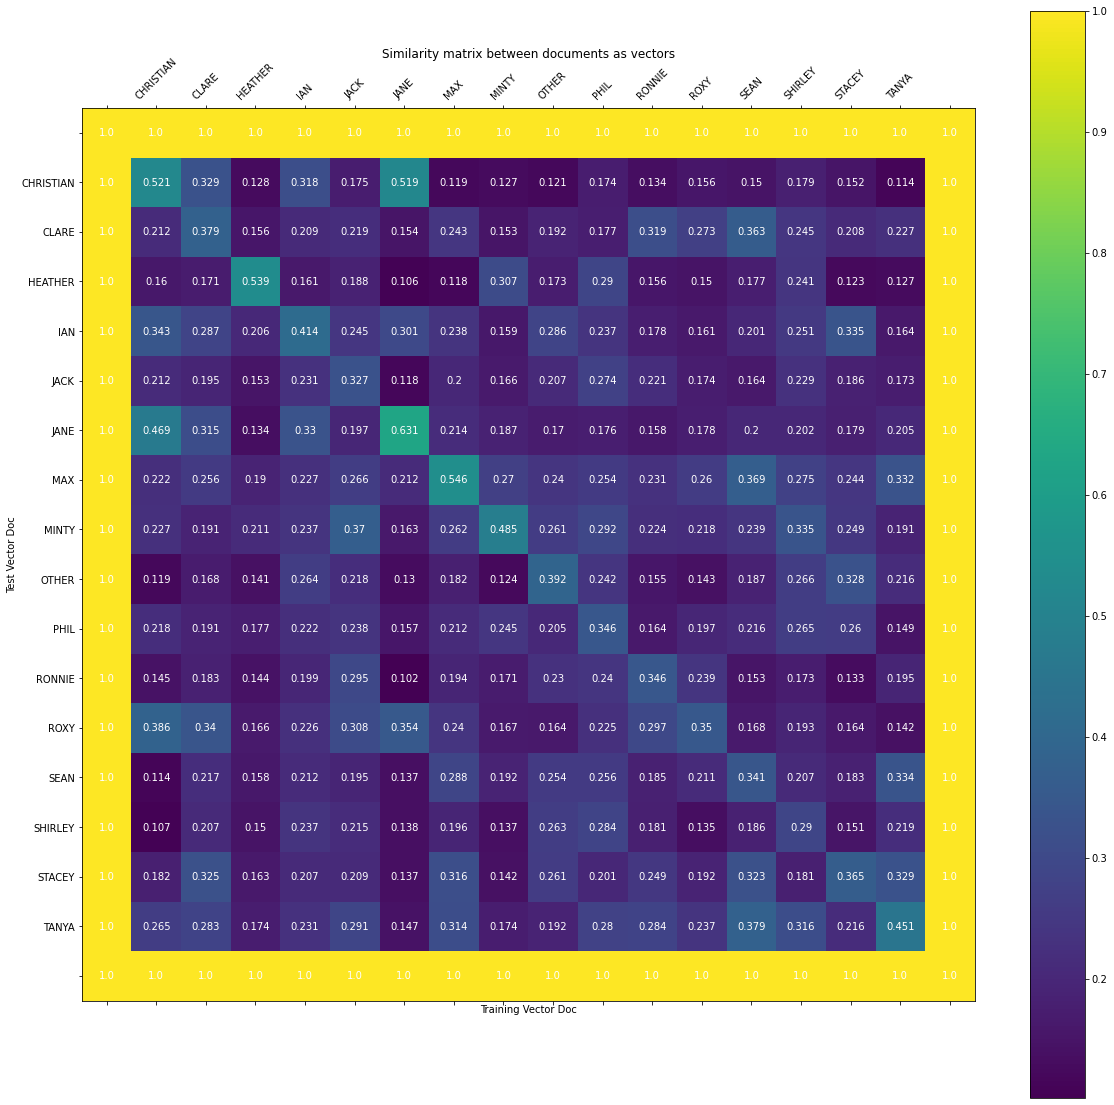

In [75]:
plot_heat_map_similarity(df)

Analysing the similarity results
 So far we run on the 90%/10% training/validation split, identifing the heldout character vectors ranked closest to each character's training vector which are not the character themselves, and those furthest away, as displayed using the `plot_heat_map_similarity` function. Closely observing why there isn't a successful highest match between the target character in the training set and that character's vector in the heldout set yet by identifying how their language use is similar, resulting in similar word or ngram features.

In [76]:
def compute_IR_evaluation_scores_1(train_feature_matrix, test_feature_matrix, train_labels, test_labels):
    """
    Computes an information retrieval based on training data feature matrix and test data feature matrix
    returns 4-tuple:
    ::mean_rank:: mean of the ranking of the target document in terms of similarity to the query/test document
    1 is the best possible score.
    ::mean_cosine_similarity:: mean cosine similarity score for the target document vs. the test document of the same class
    ::accuracy:: proportion of test documents correctly classified
    ::df:: a data frame with all the similarity measures of the test documents vs. train documents
    
    params:
    ::train_feature_matrix:: a numpy matrix N x M shape where N = number of characters M = number of features
    ::test_feature_matrix::  a numpy matrix N x M shape where N = number of characters M = number of features
    ::train_labels:: a list of character names for the training data in order consistent with train_feature_matrix
    ::test_labels:: a list of character names for the test data in order consistent with test_feature_matrix
    """
    rankings = []
    all_cosine_similarities = []
    pairwise_cosine_similarity = []
    pairs = []
    correct = 0
    for i, target in enumerate(test_labels):
        # compare the left out character against the mean
        idx = i 
        fm_1 = test_feature_matrix.toarray()[idx]
        all_sims = {}
        # print("target:", target)
        for j, other in enumerate(train_labels):
            fm_2 = train_feature_matrix.toarray()[j]
            manual_cosine_similarity = compute_cosine_similarity(fm_1, fm_2)
            pairs.append((target, other))
            pairwise_cosine_similarity.append(manual_cosine_similarity)
            if other == target:
                all_cosine_similarities.append(manual_cosine_similarity)
            all_sims[other] = manual_cosine_similarity

           # print(target, other, manual_cosine_similarity)
        sorted_similarities = sorted(all_sims.items(),key=lambda x:x[1],reverse=True)
        # print(sorted_similarities)
        ranking = {key[0]: rank for rank, key in enumerate(sorted_similarities, 1)}
        print(sorted_similarities[0])
        print("Ranking for target", ranking[target], target)
        if ranking[target] == 1:
            correct += 1
        rankings.append(ranking[target])
        # print("*****")
    mean_rank = np.mean(rankings)
    mean_cosine_similarity = np.mean(all_cosine_similarities)
    accuracy = correct/len(test_labels)
    print("mean rank", np.mean(rankings))
    print("mean cosine similarity", mean_cosine_similarity)
    print(correct, "correct out of", len(test_labels), "/ accuracy:", accuracy )
    
    # get a dafaframe showing all the similarity scores of training vs test docs
    df = pd.DataFrame({'doc1': [x[0] for x in pairs], 'doc2': [x[1] for x in pairs],
                       'similarity': pairwise_cosine_similarity})

    # display characters which are most similar and least similar
    # df.loc[[df.similarity.values.argmax(), df.similarity.values.argmin()]]
    return (mean_rank, mean_cosine_similarity, accuracy, df)

In [77]:
mean_rank, mean_cosine_simliarity, acc, df1 = compute_IR_evaluation_scores_1(training_matrix, val_matrix, train_labels, val_labels)

('CHRISTIAN', 0.5211138388370845)
Ranking for target 1 CHRISTIAN
('CLARE', 0.3792344001495003)
Ranking for target 1 CLARE
('HEATHER', 0.5394290746472238)
Ranking for target 1 HEATHER
('IAN', 0.41416253554826)
Ranking for target 1 IAN
('JACK', 0.3268860626803644)
Ranking for target 1 JACK
('JANE', 0.6312080192583279)
Ranking for target 1 JANE
('MAX', 0.5460033898390404)
Ranking for target 1 MAX
('MINTY', 0.4847025519571617)
Ranking for target 1 MINTY
('OTHER', 0.39153391701426227)
Ranking for target 1 OTHER
('PHIL', 0.34608003951716093)
Ranking for target 1 PHIL
('RONNIE', 0.3464362864529339)
Ranking for target 1 RONNIE
('CHRISTIAN', 0.3855654474738553)
Ranking for target 3 ROXY
('SEAN', 0.3412119629167535)
Ranking for target 1 SEAN
('SHIRLEY', 0.29047727657002587)
Ranking for target 1 SHIRLEY
('STACEY', 0.3650523614522695)
Ranking for target 1 STACEY
('TANYA', 0.4505745387689611)
Ranking for target 1 TANYA
mean rank 1.125
mean cosine similarity 0.4202349024598916
15 correct out of 16 /

  There must be a highest match between 'ROXY' target charecter spoken lines and 'ROXY' train charecter spoken lines. From the above output we can observe that 'CHRISTIAN' training charecter spoken lines has a highest match with the 'ROXY' charecter spoken lines. 

In [78]:
a=df1[df1['doc1']=='ROXY']
a.sort_values(by='similarity',ascending=False)[:3]

,doc1,doc2,similarity
176,ROXY,CHRISTIAN,0.385565
181,ROXY,JANE,0.353831
187,ROXY,ROXY,0.349652


In [80]:
from nltk import ngrams

In [81]:
"""
Extracting words spoken by ROXY from the val_data 
"""
for key,doc in val_corpus:
  if key=='ROXY':
    n=1
    features = to_feature_vector_dictionary(ngrams(doc,n),[])
    print(features)

{('import',): 1, ('_eol_',): 40, ('sorri',): 1, ('think',): 3, ('half',): 1, ('cut',): 1, ('mayb',): 1, ('go',): 3, ('sort',): 1, ('pretti',): 1, ('sight',): 1, ('shifti',): 1, ('slimey',): 1, ('littl',): 1, ('jack',): 2, ('sister',): 1, ('ian',): 4, ('beal',): 3, ('ah',): 1, ('poor',): 1, ('thing',): 1, ('roxi',): 2, ('mitchel',): 1, ('cours',): 1, ('know',): 1, ('nearli',): 1, ('marri',): 1, ('call',): 1, ('first',): 1, ('wed',): 1, ('jane',): 1, ('affair',): 1, ('cousin',): 1, ('grant',): 1, ('seen',): 1, ('year',): 1, ('differ',): 1, ('mean',): 1, ('ysed',): 1, ('para',): 1, ('somewher',): 2, ('oh',): 1, ('ron',): 1, ('come',): 1, ('need',): 1, ('move',): 3, ('clean',): 1, ('jumper',): 1, ('back',): 2, ('ronni',): 2, ('pleas',): 2, ('alrigh',): 1, ('well',): 1, ('unarrang',): 1, ('make',): 1, ('huge',): 1, ('mistak',): 1, ('want',): 1, ('best',): 2, ('regret',): 1, ('trust',): 1, ('beg',): 1, ('slept',): 1, ('selena',): 1, ('would',): 1, ('tell',): 1, ('truth',): 1, ('swear',): 1, 

In [82]:
"""
Extracting words spoken by CHRISTIAN from the val_data 
"""
for key,doc in training_corpus:
  if key=='CHRISTIAN':
    n=1
    features = to_feature_vector_dictionary(ngrams(doc,n),[])
    print(features)

{('lesley',): 3, ('realli',): 10, ('glad',): 2, ('must',): 2, ('ian',): 29, ('_eol_',): 342, ('partner',): 2, ('ashley',): 3, ('love',): 10, ('littl',): 3, ('place',): 3, ('seen',): 4, ('flesh',): 1, ('compar',): 1, ('way',): 7, ('describ',): 1, ('keep',): 4, ('forget',): 4, ('chang',): 1, ('name',): 2, ('would',): 4, ('therapist',): 1, ('bloke',): 4, ('make',): 11, ('might',): 9, ('say',): 12, ('indic',): 1, ('attempt',): 1, ('run',): 4, ('away',): 4, ('someth',): 6, ('let',): 8, ('go',): 13, ('amongst',): 1, ('thing',): 6, ('sister',): 3, ('call',): 5, ('hate',): 2, ('relationship',): 1, ('right',): 6, ('jane',): 19, ('much',): 3, ('break',): 1, ('heart',): 1, ('bottl',): 2, ('best',): 3, ('champagn',): 1, ('pleas',): 1, ('start',): 4, ('count',): 3, ('penni',): 1, ('pay',): 5, ('ash',): 3, ('know',): 14, ('exactli',): 3, ('imagin',): 1, ('kind',): 2, ('end',): 2, ('marri',): 1, ('mean',): 6, ('david',): 3, ('alway',): 4, ('tough',): 1, ('act',): 3, ('follow',): 1, ('word',): 1, ('th

There are lot of similar words spoken by 'roxy' and 'christian' charecters' from the validation and train data.some of the observations are 'run','shop','ian',,'lucki','marri','christian','fanci','think', 'bag','littl','bloke','might','proud','one','come','earth','shirt','thing','need','someth','today','top','grandios','tell','put','dinner','togeth','two','definit','bloke','dead','never','walford','got','lot'.

In [84]:
# redo on all training data with the first 400 character lines used
train_character_docs = create_character_document_from_dataframe(all_train_data, max_line_count=400)
# print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    # print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
# print("total words", total_words)

training_corpus = [(name, pre_process(doc)) for name, doc in train_character_docs.items()]
train_labels = [name for name, doc in training_corpus]

corpusVectorizer = DictVectorizer()   # initialize a corpusVectorizor which will output sparse vectors from dicts
# Any matrix transformers (e.g. tf-idf transformers) should be initialized here


training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)
seed(0) # set a seed for reproducibility so same split is used each time

epsiode_scene_column = test_data.Episode.astype(str) + "-" + test_data.Scene.astype(str)
test_data['episode_scene'] = epsiode_scene_column
# get the test data using 40 lines per character
test_character_docs = create_character_document_from_dataframe(test_data, max_line_count=40)
# print('Num. Characters: ',len(test_character_docs.keys()),"\n")
total_words = 0
for name in test_character_docs.keys():
    # print(name, 'Number of Words: ',len(test_character_docs[name].split()))
    total_words += len(test_character_docs[name].split())
# print("total words", total_words)

# create list of pairs of (character name, pre-processed character) 
test_corpus = [(name, pre_process(doc)) for name, doc in test_character_docs.items()]
test_labels = [name for name, doc in test_corpus]


# Just transform the val_feature_matrix, don't fit
test_feature_matrix = create_document_matrix_from_corpus(test_corpus, fitting=False)


mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, test_feature_matrix, train_labels, test_labels)

lines per character {'SHIRLEY': 400, 'OTHER': 400, 'JACK': 400, 'RONNIE': 400, 'TANYA': 400, 'SEAN': 400, 'ROXY': 400, 'HEATHER': 400, 'MAX': 400, 'IAN': 400, 'JANE': 400, 'STACEY': 400, 'PHIL': 400, 'MINTY': 400, 'CHRISTIAN': 385, 'CLARE': 400}
lines per character {'SHIRLEY': 40, 'OTHER': 40, 'HEATHER': 40, 'PHIL': 40, 'SEAN': 40, 'TANYA': 40, 'MAX': 40, 'JACK': 40, 'IAN': 40, 'JANE': 40, 'STACEY': 40, 'ROXY': 40, 'RONNIE': 40, 'CHRISTIAN': 40, 'MINTY': 40, 'CLARE': 40}
mean rank 1.0625
mean cosine similarity 0.46196310589124584
15 correct out of 16 / accuracy: 0.9375
